# Planet IX Investigations (Following [Batygin & Brown (2016)](http://arxiv.org/abs/1601.05438))

You will need to Hanno Rein's excellent [rebound](https://github.com/hannorein/rebound) N-body code, my [plotutils](https://github.com/farr/plotutils) package, and [seaborn](https://stanford.edu/~mwaskom/software/seaborn/index.html) to make the plots look pretty.  Of course, numpy and scipy are also required.  Preliminary imports and simple functions:

In [58]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
import gzip
import os
import pickle
import plotutils.plotutils as pu
import rebound as re
import seaborn
import sys
import utils as u

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [8]:
def angular_difference(xs, ys):
    xs = np.atleast_1d(xs).copy()
    ys = np.atleast_1d(ys).copy()
    
    xs = np.fmod(xs, 2*pi)
    ys = np.fmod(ys, 2*pi)
    
    xs[xs<0] += 2*pi
    ys[ys<0] += 2*pi
    
    # Now all angles between 0 and 2*pi
    zs = xs - ys
    zs[zs < 0] += 2*pi
    
    return zs

In [9]:
seaborn.set_style('ticks')

## Figure 4: Phase Portraits for Planar Perturber

### Quick Integrator Check

Here and throughout, we will be using the ``whfast`` integrator from rebound because it does a good job of capturing the resonant behaviours of the system even in an approximate integration.  Batygin & Brown use a timestep that is 1/20 of the shortest period in the system (but with an integrator that will transition to exact dynamics if necessary); that would correspond to $dt \simeq 4$ for us.  

We will check that this gives reasonably stable evolution of the "canonical" perturber from B&B, with 1-degree inclination scatter (to avoid numerical issues with $\iota \equiv 0$).

In [47]:
sim = u.outer_solar_system()
sim = u.add_canonical_planar_perturber(sim)
sim.status()

Searching NASA Horizons for 'Sun'... Found: Sun (10).
Searching NASA Horizons for 'Jupiter'... Found: Jupiter Barycenter (5).
Searching NASA Horizons for 'Saturn'... Found: Saturn Barycenter (6).
Searching NASA Horizons for 'Uranus'... Found: Uranus Barycenter (7).
Searching NASA Horizons for 'Neptune'... Found: Neptune Barycenter (8).
---------------------------------
REBOUND version:     	2.13.5
REBOUND built on:    	Feb 22 2016 15:29:40
Number of particles: 	6
Selected integrator: 	whfast
Simulation time:     	0.000000
Current timestep:    	4.000000
---------------------------------
<rebound.Particle object, id=0 m=1.0 x=0.00376524683101 y=0.00178102309647 z=-0.000162366165175 vx=1.67972346255e-05 vy=0.000402869447413 vz=-9.37301970739e-07>
<rebound.Particle object, id=0 m=0.000954791915211 x=-5.28379510767 y=1.21317798874 z=0.113122795752 vx=-0.103271394496 vy=-0.406869015654 vz=0.00400136215533>
<rebound.Particle object, id=0 m=0.000285885672722 x=-3.44289005018 y=-9.39936213249 z

In [48]:
%%time 
orbs = []
ts = []
for t in linspace(0, 2*pi*1e8, 1000): # Store state every 1 Myr for 1 Gyr evolution
    sim.integrate(t, exact_finish_time=0)
    ts.append(sim.t)
    orbs.append(sim.calculate_orbits())
ts = array(ts)
orbs = array(orbs).T  # (Nbodies-1, Ntimes) array of orbits

CPU times: user 3min 16s, sys: 1.41 s, total: 3min 18s
Wall time: 3min 22s


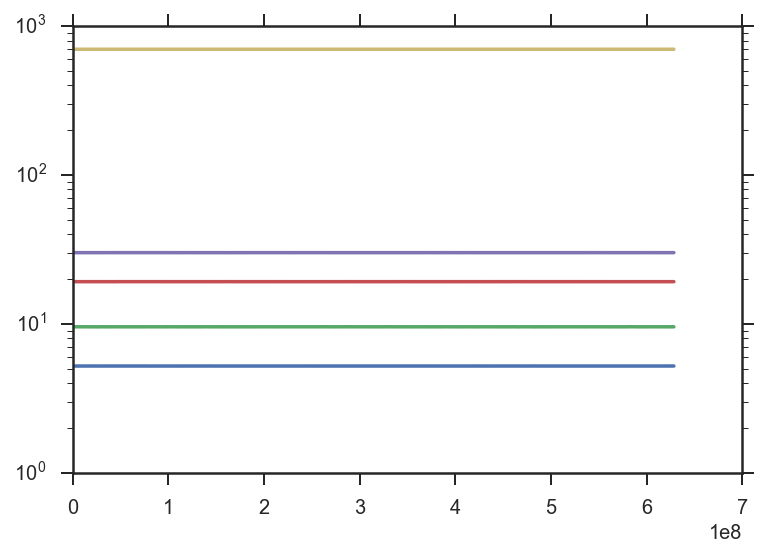

In [49]:
for i in range(orbs.shape[0]):
    plot(ts, orbs[i,:]['a'])
yscale('log')

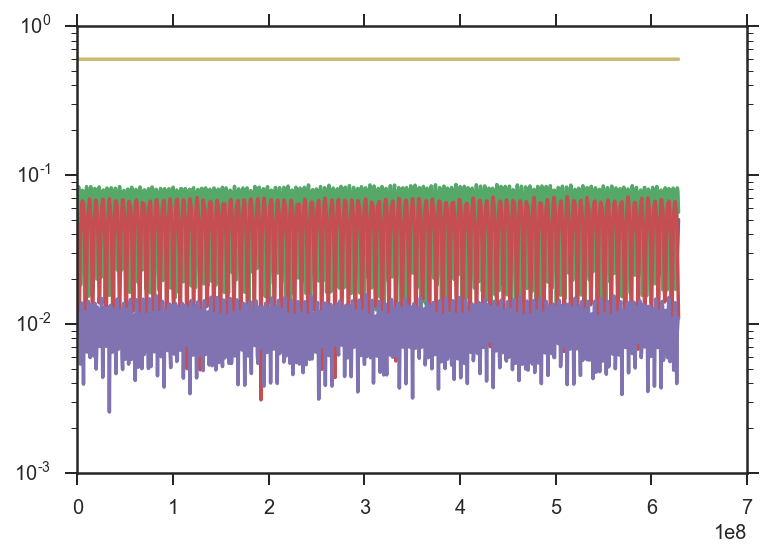

In [50]:
for i in range(orbs.shape[0]):
    plot(ts, orbs[i,:]['e'])
yscale('log')

### Let's Check Phase Portrait

We add 400 test masses linearly spaced in $e$ and $\varpi$ to construct the secular phase portrait.

In [55]:
sim = u.outer_solar_system()
sim = u.add_canonical_planar_perturber(sim)
for e in linspace(0, 1, 11)[:-1]:
    for pomega in linspace(0, 2*pi, 11)[:-1]:
        sim.add(m=0, a=450, e=e, inc=abs(pi/180.0*randn()), pomega=pomega, l=2*pi*rand())
sim.N_active = 6

Searching NASA Horizons for 'Sun'... Found: Sun (10).
Searching NASA Horizons for 'Jupiter'... Found: Jupiter Barycenter (5).
Searching NASA Horizons for 'Saturn'... Found: Saturn Barycenter (6).
Searching NASA Horizons for 'Uranus'... Found: Uranus Barycenter (7).
Searching NASA Horizons for 'Neptune'... Found: Neptune Barycenter (8).


In [56]:
%%time
ts = []
orbs = []
for t in linspace(0, 2*pi*1e7, 1000):
    sim.integrate(t, exact_finish_time=0)
    ts.append(sim.t)
    orbs.append(sim.calculate_orbits())
ts = array(ts)
orbs = array(orbs).T

CPU times: user 6min 13s, sys: 2.79 s, total: 6min 16s
Wall time: 6min 24s


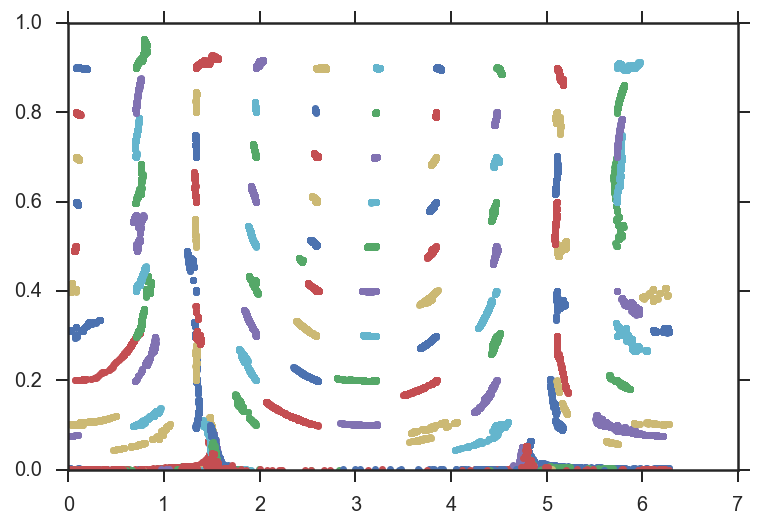

In [57]:
for i in range(6, orbs.shape[0]):
    plot(angular_difference(orbs[i,:]['pomega'], orbs[4,:]['pomega']), orbs[i,:]['e'], '.')